I computed realizations of multiple HODs for a few statistics in the darksky boxes. This notebook is gonna combine them into a jackknife covmat. It'll also add some estimate of the shape noise contribution. 

In [43]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib.colors as colors

In [44]:
import numpy as np
from glob import glob
from os import path

In [45]:
#shape_noise_covmat = np.load('/u/ki/swmclau2/Git/pearce/bin/covmat/shape_noise.npy')
shape_noise_covmat = np.load('./Hankel_transform/shape_noise.npy')

In [46]:
print np.sqrt(np.diag(shape_noise_covmat))

[1.22319799 1.17388107 1.08125784 0.82562805 0.68741346 0.53755873
 0.39319286 0.28290232 0.21146068 0.15968512 0.11930769 0.09051979
 0.06915136 0.05382245 0.04261482 0.03469324 0.02894981 0.02459145]


In [47]:
output_dir = '/home/users/swmclau2/Git/pearce/bin/covmat/ds14_covmat_v2/'

In [48]:
outputs = sorted(glob(path.join(output_dir, 'wp_ds_cic_darksky_obs_???_v2.npy')))
print len(outputs)

512


In [49]:
N = len(outputs) # Should be 512, but a few may not have finished. Should make sure that those get reestarted, but likely not super important
all_outputs = np.zeros((N, 5,  2*18 + 14)) # num bins and num HODs 

In [50]:
2*18+14

50

In [51]:
for i,output_file in enumerate(outputs):
    output = np.load(output_file)

    all_outputs[i] = output#.mean(axis = 0)

In [52]:
all_outputs.shape

(512, 5, 50)

In [53]:
rp_bins = np.logspace(-1.0, 1.6, 19)
cic_bins = np.round(np.r_[np.linspace(1, 9, 8), np.round(np.logspace(1,2, 7))] )

In [54]:
cic_bins

array([  1.,   2.,   3.,   4.,   6.,   7.,   8.,   9.,  10.,  15.,  22.,
        32.,  46.,  68., 100.])

In [55]:
rp_points = (rp_bins[1:]+rp_bins[:-1])/2.0
cic_points = (cic_bins[1:]+cic_bins[:-1])/2.0

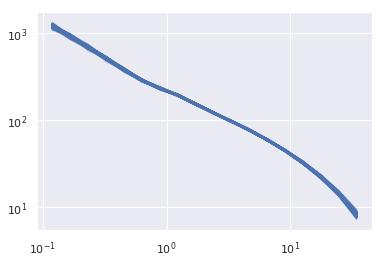

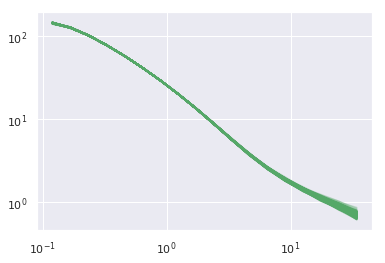

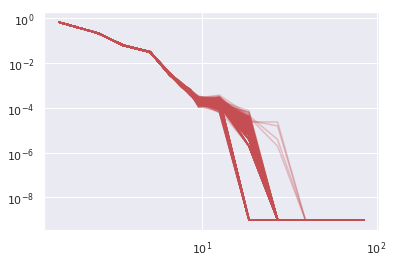

In [56]:
hod_idx = 2
plt.plot(rp_points, (all_outputs[:,hod_idx, :18]).T, alpha = 0.3, color = 'b')
plt.loglog();
plt.show();
plt.plot(rp_points, (all_outputs[:,hod_idx, 18:36]).T, alpha = 0.3, color = 'g')
plt.loglog();
plt.show();
plt.plot(cic_points, all_outputs[:, hod_idx, 36:].T, alpha = 0.3, color = 'r')
plt.loglog();
plt.show();

In [57]:
mean = all_outputs.mean(axis = 0)

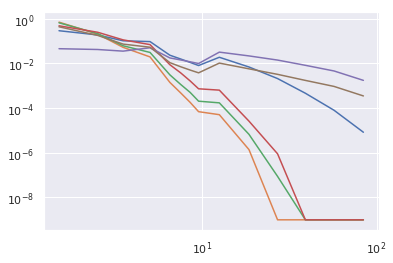

In [58]:
for i in mean:
    plt.plot(cic_points, i[36:])
plt.plot(cic_points, mean.mean(axis=0)[36:])
plt.loglog();

In [59]:
R =(all_outputs - mean)

cov = np.zeros((R.shape[2], R.shape[2]))
for i in xrange(R.shape[1]):
    cov+= R[:,i].T.dot(R[:,i])#/(N-1)
    
cov/=R.shape[1]*(N-1)

In [60]:
cov.shape

(50, 50)

In [61]:
np.min(cov)

-60.12955951942387

In [62]:
def cov_to_corr(cov):
    std = np.sqrt(np.diag(cov))
    
    denom = np.outer(std, std)
    
    return cov/denom

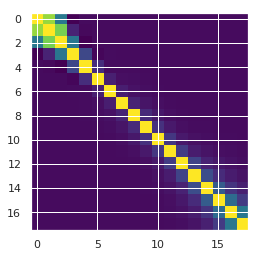

In [63]:
plt.imshow(cov_to_corr(shape_noise_covmat), cmap = 'viridis')

In [64]:
print(cov_to_corr(shape_noise_covmat))[:5, :5]

[[ 1.00000000e+00  8.42406214e-01  3.86208997e-01 -2.93016279e-02
  -1.97547565e-04]
 [ 8.42406214e-01  1.00000000e+00  7.88979947e-01  7.39946700e-02
  -3.67370677e-03]
 [ 3.86208997e-01  7.88979947e-01  1.00000000e+00  3.73641155e-01
  -2.94861577e-02]
 [-2.93016279e-02  7.39946700e-02  3.73641155e-01  1.00000000e+00
   1.92649413e-01]
 [-1.97547565e-04 -3.67370677e-03 -2.94861577e-02  1.92649413e-01
   1.00000000e+00]]


In [65]:
from copy import deepcopy

In [66]:
full_cov = deepcopy(cov)

full_cov[18:36][:, 18:36] = full_cov[18:36][:, 18:36]+ shape_noise_covmat

In [67]:
corr = cov_to_corr(cov)
full_corr = cov_to_corr(full_cov)

In [68]:
cmap = sns.diverging_palette(240, 10, n=7, as_cmap = True)

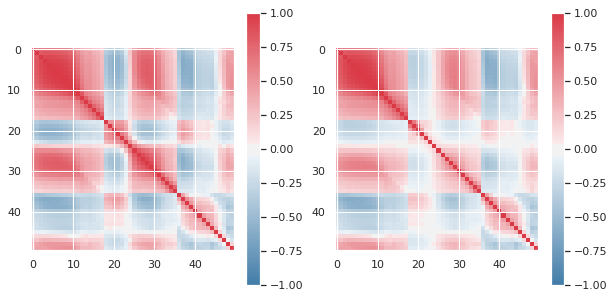

In [69]:
fig = plt.figure(figsize = (10, 5))
plt.subplot(121)
im = plt.imshow(corr, cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(122)
im = plt.imshow(full_corr, cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

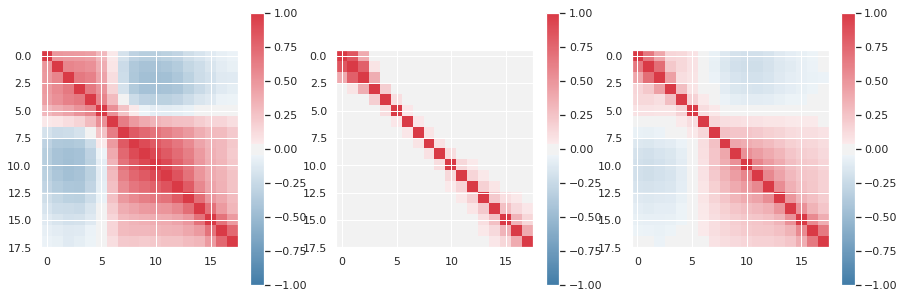

In [70]:
fig = plt.figure(figsize = (15, 5))
plt.subplot(131)
im = plt.imshow(corr[18:36][:, 18:36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(132)
im = plt.imshow(cov_to_corr(shape_noise_covmat), cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.subplot(133)
im = plt.imshow(full_corr[18:36][:, 18:36], cmap = cmap, vmin = -1)
plt.colorbar(im);
plt.show()

In [71]:
np.sqrt(np.diag(full_corr)[18:36])

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1.])

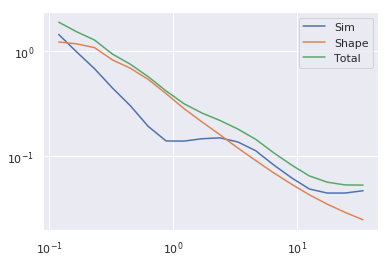

In [72]:
plt.plot(rp_points, np.sqrt(np.diag(cov)[18:36]), label = 'Sim')
plt.plot(rp_points,np.sqrt(np.diag(shape_noise_covmat)), label = 'Shape')

plt.plot(rp_points,np.sqrt(np.diag(full_cov)[18:36]), label = 'Total')
#plt.xscale('log')
plt.loglog();
plt.legend(loc = 'best')

In [73]:
print full_corr[30:30+5][:, 30:30+5]

[[1.         0.54511238 0.35667514 0.26870056 0.23114348]
 [0.54511238 1.         0.4974454  0.32982946 0.27019298]
 [0.35667514 0.4974454  1.         0.51946129 0.34110461]
 [0.26870056 0.32982946 0.51946129 1.         0.56104468]
 [0.23114348 0.27019298 0.34110461 0.56104468 1.        ]]


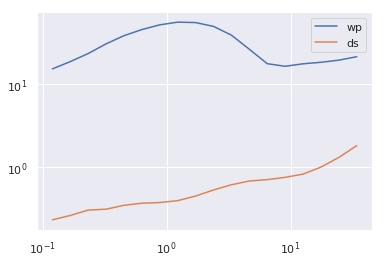

In [74]:
plt.plot(rp_points, rp_points*np.sqrt(np.diag(full_cov[:18, :18]) ), label = 'wp')
#plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat) ), label = 'Shape')
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, rp_points*np.sqrt(np.diag(full_cov[18:36, 18:36]) ), label = 'ds')

plt.loglog()
plt.legend(loc='best')

In [75]:
print  np.sqrt(np.diag(full_cov[18:36, 18:36]) )

[1.89210565 1.53202442 1.27754492 0.9382252  0.75077738 0.57067269
 0.41704941 0.31503967 0.25699409 0.21834394 0.18102486 0.1442535
 0.10748054 0.08212083 0.06448684 0.05623913 0.05291413 0.05268832]


In [76]:
#emu covs
emu_cov_fnames = ['/home/users/swmclau2/Git/pearce/bin/optimization/wp_hod_emu_cov.npy',
                  '/home/users/swmclau2/Git/pearce/bin/optimization/ds_hod_emu_cov.npy']

In [77]:
emu_cov = np.zeros_like(full_cov[:36][:, :36])

for i, fname in enumerate(emu_cov_fnames):
    
    emu_cov[i*18:(i+1)*18][:, i*18:(i+1)*18] = np.load(fname)

In [78]:
emu_corr = cov_to_corr(emu_cov)

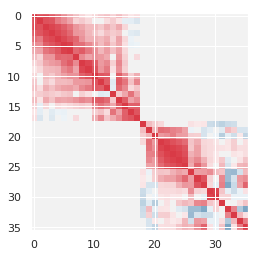

In [79]:
plt.imshow(emu_corr, cmap = cmap, vmin = -1)

In [80]:
full_emu_cov = full_cov[:36][:, :36] + emu_cov

In [81]:
full_emu_corr = cov_to_corr(full_emu_cov)

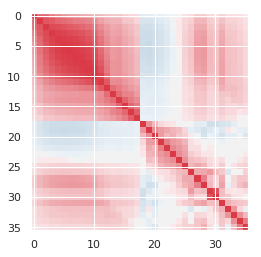

In [82]:
plt.imshow(full_emu_corr, cmap = cmap, vmin = -1)

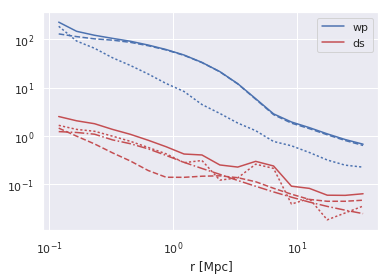

In [83]:
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[:18, :18]) ), label = 'wp', color = 'b')
plt.plot(rp_points, np.sqrt(np.diag(cov[:18, :18]) ), color = 'b', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[:18, :18]) ), color = 'b', ls = ':')


#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'ds', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ),  color = 'r', ls = '--')
plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'r',  ls = '-.')

#plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

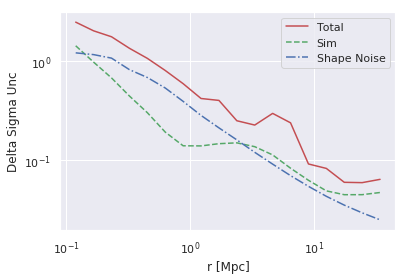

In [84]:
#plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ), label = 'ds')
plt.plot(rp_points, np.sqrt(np.diag(full_emu_cov[18:36, 18:36])) , label = 'Total', color ='r')
plt.plot(rp_points, np.sqrt(np.diag(cov[18:36, 18:36]) ),  color = 'g', label = 'Sim', ls = '--')
#plt.plot(rp_points, np.sqrt(np.diag(emu_cov[18:36, 18:36]) ), color = 'r', ls = ':')
plt.plot(rp_points, np.sqrt(np.diag(shape_noise_covmat)), color = 'b', label = 'Shape Noise',ls = '-.')

plt.ylabel('Delta Sigma Unc')
plt.xlabel('r [Mpc]')
plt.loglog()
plt.legend(loc='best')

In [85]:
0.7**2

0.48999999999999994